In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.audio.augment import *
from local.vision.learner import *
from local.vision.models.xresnet import *
from local.metrics import *

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
x = AudioGetter("", recurse=True, folders=None)
files = x(p)
original_aud = AudioItem.create(files[0])

In [ ]:
a2s = AudioToSpec(n_fft = 1024, hop_length=256)

In [ ]:
original_spec = a2s(original_aud)

In [ ]:
type(original_spec[0])

<<<<<<< local


<<<<<<< local


torch.Tensor

local.audio.core.AudioSpectrogram

>>>>>>> remote


<<<<<<< local <modified: ; unchanged: text/plain>


torch.Tensor

>>>>>>> remote <removed>


>>>>>>> remote


<<<<<<< local <modified: text/plain>


<<<<<<< local


>>>>>>> remote <modified: text/plain>


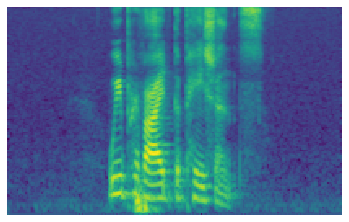

>>>>>>> remote


<<<<<<< local <unchanged>


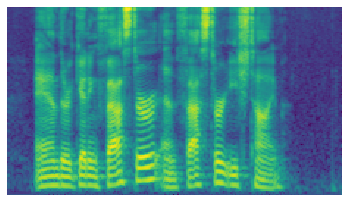

>>>>>>> remote <removed>


In [ ]:
original_spec.show()

In [ ]:
original_spec.n_fft

1024

# End-to-End Example

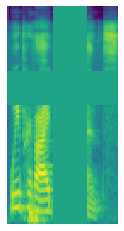

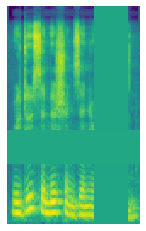

In [ ]:
items = get_audio_files(p)
oa = OpenAudio(items)
preprocesses = [oa, RemoveSilence("trim"), Resample(22050),]
augments = [AudioToSpec(n_fft=1048), MaskTime(), MaskFreq()]
functions = preprocesses + augments
pipe = Pipeline(functions, as_item=True)
for i in range(2): pipe.show(pipe(i))

<<<<<<< local


<<<<<<< local


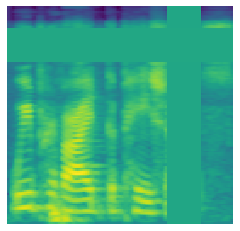

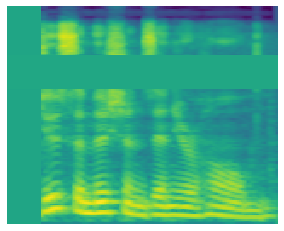

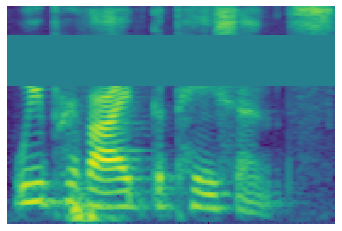

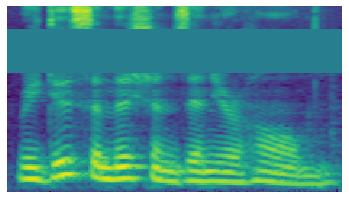

>>>>>>> remote


<<<<<<< local <unchanged>


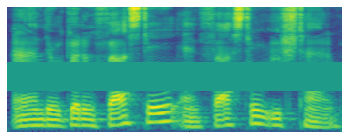

>>>>>>> remote <removed>


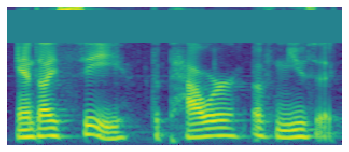

>>>>>>> remote


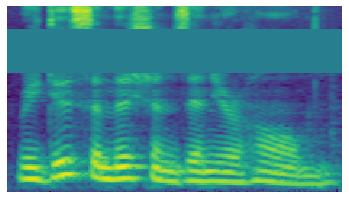

In [ ]:
items = get_audio_files(p)
oa = OpenAudio(items)
preprocesses = L(oa, RemoveSilence("trim"), Resample(22050), AudioToSpec(n_fft=2048, hop_length=256))
augments = L(MaskTime(), MaskFreq())
functions = preprocesses + augments
pipe = Pipeline(functions, as_item=True)
for i in range(2): pipe.show(pipe(i))

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

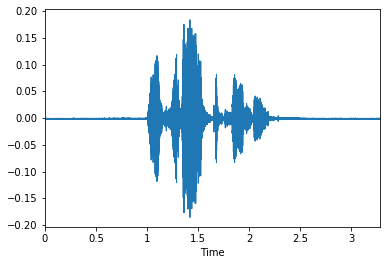

In [ ]:
labeler = lambda x: str(x).split('/')[-1][:5]
tfms = [[AudioItem.create, Resample(8000)], [labeler]]
items = get_audio_files(p)

tds = TfmdDS(items, tfms)
tds.show(tds[0])
tdl = TfmdDL(tds, bs=8, after_item=[AudioToSpec(), CropTime(1000), MaskTime(), MaskFreq()])

In [ ]:
labeler = lambda x: str(x).split('/')[-1][:5]
tfms = [[AudioItem.create, Resample(8000)], [labeler]]
items = get_audio_files(p)

tfds = TfmdDS(items, tfms)
tfds.show(tfds[0])
bs = 8
tfdl = TfmdDL(tfds, bs=bs, after_item=[AudioToSpec(hop_length=256), CropTime(1000), MaskTime(), MaskFreq()])

In [ ]:
t = tfdl.one_batch()
print(len(t[0]), "tensors with shapes", [ten.shape for ten in t[0]])
print("labels", t[1])

## Datablock and Basic End to End Training

In [ ]:
auds = DataBlock(types=(AudioItem, Category), 
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
cats = [y for _,y in auds.datasource(p)]

In [ ]:
#verify categories are being correctly assigned
test_eq(min(cats).item(), 0)
test_eq(max(cats).item(), 9)

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
a2s = AudioToSpec()
crop_2000ms = CropTime(2000)
tfms = Pipeline([a2s, crop_2000ms], as_item=True)
dbunch_cropspec = auds.databunch(p, item_tfms=tfms, bs=64)

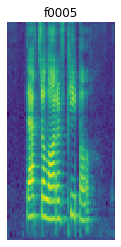

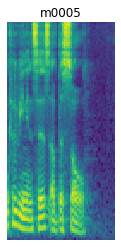

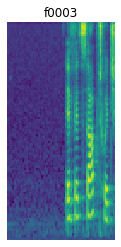

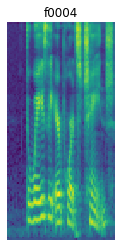

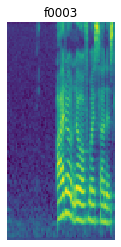

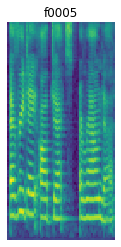

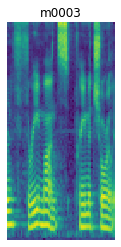

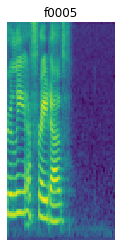

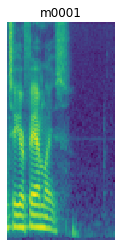

In [ ]:
dbunch_cropspec.show_batch(max_n=9)

In [ ]:
dbunch_cropspec.one_batch()[0].shape

torch.Size([64, 1, 128, 63])

In [ ]:
# credit to Kevin Bird and Hiromi Suenaga for these two lines to adjust a CNN model to take 1 channel input
def alter_learner(learn):
    learn.model[0][0].in_channels=1
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [ ]:
learn = Learner(dbunch_cropspec, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
alter_learner(learn)

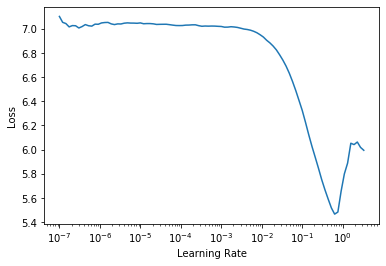

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,4.414924,2.224625,0.408854,00:06
1,2.098160,1.564576,0.494792,00:06
2,1.207936,0.792571,0.763021,00:06
3,0.779568,0.801433,0.739583,00:06
4,0.553784,0.759720,0.707031,00:06
5,0.431080,0.677614,0.769531,00:06
6,0.337672,0.291019,0.932292,00:06
7,0.287652,0.271402,0.936198,00:06
8,0.265727,0.248267,0.937500,00:06
9,0.248309,0.242732,0.955729,00:06


## Cropping signal instead of Spectrogram so that we can move on to GPU transforms

In [ ]:
auds = DataBlock(types=(AudioItem, Category), 
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
auds.datasource(p)[0]

((tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
           -6.1035e-05, -1.8311e-04]]),
  16000,
  PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')),
 tensor(3))

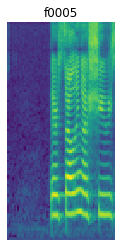

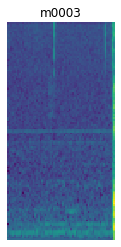

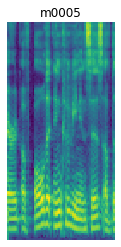

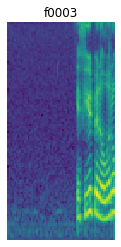

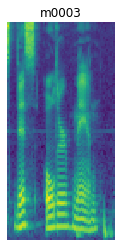

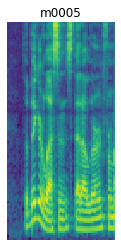

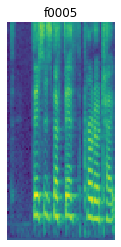

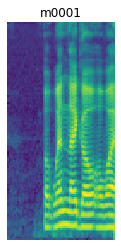

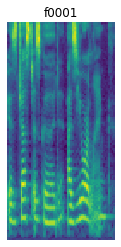

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
cropsig_2000ms = CropSignal(2000)
ds_tfms = Pipeline([cropsig_2000ms, a2s], as_item=True)
dl_tfms = Pipeline([], as_item=True)
dbunch_cropsig = auds.databunch(p, item_tfms=ds_tfms, bs=64)
dbunch_cropsig.show_batch(max_n=9)

In [ ]:
dbunch_cropsig.one_batch()[0].shape

torch.Size([64, 1, 128, 63])

In [ ]:
learn = Learner(dbunch_cropsig,
                xresnet18(),  
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
alter_learner(learn)

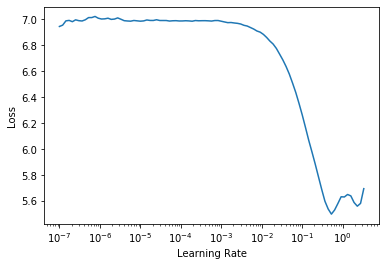

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-1)

epoch,train_loss,valid_loss,accuracy,time
0,3.424139,1.662483,0.410156,00:05
1,1.698475,2.482897,0.404948,00:05
2,1.058340,1.368424,0.519531,00:05
3,0.707638,0.797631,0.726562,00:05
4,0.491405,0.721889,0.756510,00:05
5,0.366936,0.473581,0.845052,00:05
6,0.274316,0.269948,0.917969,00:05
7,0.210735,0.184938,0.944010,00:05
8,0.181348,0.184647,0.951823,00:05
9,0.155457,0.149824,0.971354,00:05


In [ ]:
learn.unfreeze()

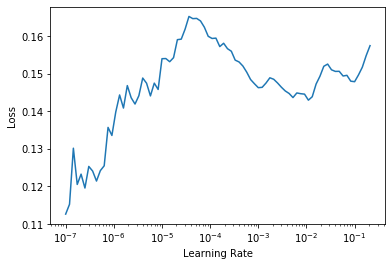

In [ ]:
learn.lr_find()

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)